# Image classification via fine-tuning/transfer learning with EfficientNet

**Author:** [Yixing Fu](https://github.com/yixingfu)<br>
**Date created:** 2020/06/30<br>
**Last modified:** 2020/07/16<br>
**Description:** Use EfficientNet with weights pre-trained on imagenet for Stanford Dogs classification.

This notebook is an extension of [Tutorial 8](https://github.com/hasibzunair/cu-comp478-lab/blob/main/Tutorial8COMP478.ipynb).

In [1]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

## Setup and data loading

This example requires TensorFlow 2.3 or above.

To use TPU, the TPU runtime must match current running TensorFlow
version. If there is a mismatch, try:

```python
from cloud_tpu_client import Client
c = Client()
c.configure_tpu_version(tf.__version__, restart_type="always")
```

In [2]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteW0Z75H/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteW0Z75H/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


When the dataset include images with various size, we need to resize them into a
shared size. The Stanford Dogs dataset includes only images at least 200x200
pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [4]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

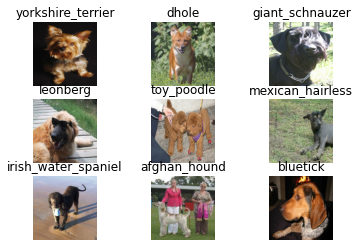

In [5]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation

We can use preprocessing layers APIs for image augmentation.

In [6]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

This `Sequential` model object can be used both as a part of
the model we later build, and as a function to preprocess
data before feeding into the model. Using them as function makes
it easy to visualize the augmented images. Here we plot 9 examples
of augmentation result of a given figure.

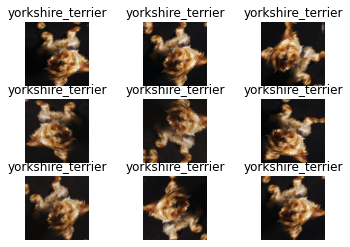

In [7]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

Note: `prefetch` and `AUTOTUNE` may in some situation improve
performance, but depends on environment and the specific dataset used.
See this [guide](https://www.tensorflow.org/guide/data_performance)
for more information on data pipeline performance.

In [8]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


In [10]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset.

In [13]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0


# Old model: from 
# Tutorial 8(https://github.com/hasibzunair/cu-comp478-lab/blob/main/Tutorial8COMP478.ipynb)

# inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# x = img_augmentation(inputs)
# outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

# model = tf.keras.Model(inputs, outputs)
# model.compile(
#     optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
# )

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


The first step to transfer learning is to freeze all layers and train only the top
layers. For this step, a relatively large learning rate (1e-2) can be used.
Note that validation accuracy and loss will usually be better than training
accuracy and loss. This is because the regularization is strong, which only
suppresses training-time metrics.

Note that the convergence may take up to 50 epochs depending on choice of learning rate.
If image augmentation layers were not
applied, the validation accuracy may only reach ~60%.

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


16711680/16705208 [==============================] - 0s 0us/step
Epoch 1/10
187/187 - 78s - loss: 3.4908 - accuracy: 0.3767 - val_loss: 0.9829 - val_accuracy: 0.7065
Epoch 2/10
187/187 - 37s - loss: 1.8431 - accuracy: 0.5328 - val_loss: 0.7956 - val_accuracy: 0.7570
Epoch 3/10
187/187 - 36s - loss: 1.5532 - accuracy: 0.5747 - val_loss: 0.7811 - val_accuracy: 0.7626
Epoch 4/10
187/187 - 36s - loss: 1.4394 - accuracy: 0.6025 - val_loss: 0.7722 - val_accuracy: 0.7615
Epoch 5/10
187/187 - 37s - loss: 1.3673 - accuracy: 0.6159 - val_loss: 0.7915 - val_accuracy: 0.7659
Epoch 6/10
187/187 - 37s - loss: 1.3676 - accuracy: 0.6133 - val_loss: 0.7984 - val_accuracy: 0.7605
Epoch 7/10
187/187 - 36s - loss: 1.3026 - accuracy: 0.6328 - val_loss: 0.8121 - val_accuracy: 0.7627
Epoch 8/10
187/187 - 37s - loss: 1.3121 - accuracy: 0.6274 - val_loss: 0.8332 - val_accuracy: 0.7556
Epoch 9/10
187/187 - 37s - loss: 1.3070 - accuracy: 0.6296 - val_loss: 0.8723 - val_accuracy: 0.7449
Epoch 10/10
187/187 - 37s 

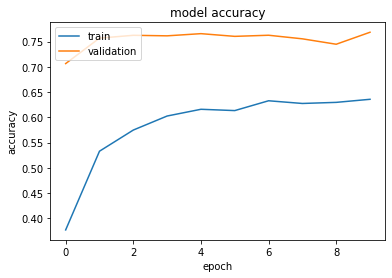

In [14]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

The second step is to unfreeze a number of layers and fit the model using smaller
learning rate. In this example we show unfreezing all layers, but depending on
specific dataset it may be desireble to only unfreeze a fraction of all layers.

When the feature extraction with
pretrained model works good enough, this step would give a very limited gain on
validation accuracy. In our case we only see a small improvement,
as ImageNet pretraining already exposed the model to a good amount of dogs.

On the other hand, when we use pretrained weights on a dataset that is more different
from ImageNet, this fine-tuning step can be crucial as the feature extractor also
needs to be adjusted by a considerable amount. Such a situation can be demonstrated
if choosing CIFAR-100 dataset instead, where fine-tuning boosts validation accuracy
by about 10% to pass 80% on `EfficientNetB0`.
In such a case the convergence may take more than 50 epochs.

A side note on freezing/unfreezing models: setting `trainable` of a `Model` will
simultaneously set all layers belonging to the `Model` to the same `trainable`
attribute. Each layer is trainable only if both the layer itself and the model
containing it are trainable. Hence when we need to partially freeze/unfreeze
a model, we need to make sure the `trainable` attribute of the model is set
to `True`.

Epoch 1/10
187/187 - 48s - loss: 1.0098 - accuracy: 0.7015 - val_loss: 0.6886 - val_accuracy: 0.7961
Epoch 2/10
187/187 - 39s - loss: 0.8963 - accuracy: 0.7336 - val_loss: 0.6950 - val_accuracy: 0.7924
Epoch 3/10
187/187 - 39s - loss: 0.8122 - accuracy: 0.7548 - val_loss: 0.6792 - val_accuracy: 0.7964
Epoch 4/10
187/187 - 39s - loss: 0.7802 - accuracy: 0.7651 - val_loss: 0.6957 - val_accuracy: 0.7935
Epoch 5/10
187/187 - 38s - loss: 0.7365 - accuracy: 0.7727 - val_loss: 0.6889 - val_accuracy: 0.7948
Epoch 6/10
187/187 - 39s - loss: 0.6866 - accuracy: 0.7870 - val_loss: 0.6922 - val_accuracy: 0.7929
Epoch 7/10
187/187 - 39s - loss: 0.6503 - accuracy: 0.8025 - val_loss: 0.6936 - val_accuracy: 0.7943
Epoch 8/10
187/187 - 39s - loss: 0.6298 - accuracy: 0.8052 - val_loss: 0.7000 - val_accuracy: 0.7919
Epoch 9/10
187/187 - 39s - loss: 0.5957 - accuracy: 0.8164 - val_loss: 0.7102 - val_accuracy: 0.7868
Epoch 10/10
187/187 - 39s - loss: 0.5746 - accuracy: 0.8229 - val_loss: 0.7080 - val_accura

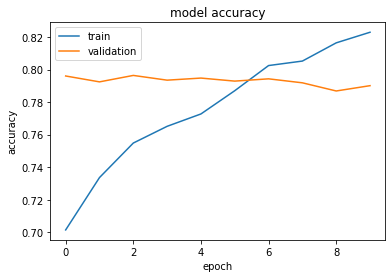

In [15]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

## Run inference on new data

Saving gordon-setter.jpg to gordon-setter (1).jpg
This image is gordon_setter with 99.99 percent confidence.


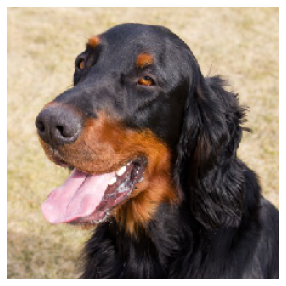

In [17]:
import keras 
import numpy as np
from google.colab import files

uploaded = files.upload()

img = keras.preprocessing.image.load_img(
    "gordon-setter.jpg", target_size=(IMG_SIZE,IMG_SIZE,3)
)
# Plot image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")

# Preprocess image
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
# Make predictions on images
predictions = model.predict(img_array)
score = predictions[0]
# Get index for highest confidence class
idx = np.argmax(score)

print(
    "This image is %s with %.2f percent confidence."
    % (str(format_label(63)), score[idx]*100)
)

More details are available [here](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/). You can also read more about transfer learning [here](https://cs231n.github.io/transfer-learning/).